# Introduction

This noteboook summarize the work i've done on **Stock Market Prediction** as part of my portfolio project at Udacity for the **Machine Learning Engineer Nanodegree**.

This project is inspired by the excellent course __Investment and Trading__ offered by Udacity and Georgia Tech.

Investment firms, hedge funds and even individuals have been using financial models to better understand market behavior and make profitable investments and trades. A wealth of information is available in the form of historical stock prices and company performance data, suitable for machine learning algorithms to process.

For this project, the task is to build a stock price predictor that takes daily trading data over a certain date range as input, and outputs projected estimates for given query dates.

First of all, we need a list of module and some data.  The data will be collected from [Quandl](https://www.quandl.com/), a remote data service.  

For reader interested to run the project locally, make sure you register yourself on Quandl and you have stored the auth key in the auth.txt file at the root of this project.

In [1]:
import Quandl
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import re
import scipy.optimize as spo
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer, mean_absolute_error

%matplotlib inline
import matplotlib as mpl
mpl.rc('figure', figsize=(15, 5))

try:
    auth_token = open("auth.txt", "r").read().strip()
except Exception, e:
    print 'ERROR >> looks like you have not defined your auth key, please visit www.quandl.com and request an auth '\
    'key. Place the key in the auth.txt file located in the same folder as this notebook'

The idea at the base of this project is to build a model to **predict financial market's movement**.  The forecasting algorithm aims to foresee whether tomorrow’s exchange closing price is going to be lower or higher with respect to today. Next step will be to develop a trading strategy on top of that, based on our predictions, and backtest it against a benchmark.

Specifically, I’ll go through the pipeline, decision process and results I obtained trying to model a portfolio of stocks and the S&P 500 daily returns.

# Objectives

According to market efficiency theory, US stock market is semi-strong efficient market, which means all public information is calculated into a stock's current share price, meaning that neither fundamental nor technical analysis can be used to achieve superior gains in a short-term (a day or a week).  However, in this project we would like to predict the one week stock price and we are expecting our model to beat the market.  By selecting some technical indicator, we expect that machine learning algorithm will predict future up and down movelement of the market.

To that end, we will build an optimized portfolio of actions (optimized in allocations of each stocks) and compare this portfolio of actual returns versus the 7 day predictions in order to see if our model is doing better or not.
Obviously our assumption is that the model will do better, if not it will follow the market trend.

# Problem Definition
The aim of the project is to predict **future daily returns of a portfolio of stocks.**

The problem is therefore a **regression** problem.

The metric we deal with is daily return which is computed as follows:

$$ Return_i=\frac{AdjClose_i-AdjClose_{i-1}}{AdjClose_{i-1}} $$

The Return on the `i-th` day is equal to the Adjusted Stock Close Price on the `i-th` day minus the Adjusted Stock Close Price on the `(i-1)-th` day divided by the Adjusted Stock Close Price on the `(i-1)-th` day. Adjusted Close Price of a stock is its close price modified by taking into account dividends. It is common practice to use this metrics in Returns computations.

Since the beginnning we decided to focus only on S&P 500, a stock market index based on the market capitalizations of 500 large companies having common stock listed on the NYSE (New York Stock Exchange) or NASDAQ. Being such a diversified portfolio, the [S&P 500](https://en.wikipedia.org/wiki/S%26P_500_Index) index is typically used as a market benchmark, for example to compute betas of companies listed on the exchange.

It is very easy to get historical daily prices of the previous indices. Python provides easy libraries to handle the download. The data can be pulled down from Yahoo Finance or Quandl and cleanly formatted into a dataframe with the following columns:

    Date : in days
    Open : price of the stock at the opening of the trading (in US dollars)
    High : highest price of the stock during the trading day (in US dollars)
    Low : lowest price of the stock during the trading day (in US dollars)
    Close : price of the stock at the closing of the trading (in US dollars)
    Volume : amount of stocks traded (in US dollars)
    Adj Close : price of the stock at the closing of the trading adjusted with dividends (in US dollars)

For this project we choose to use Quandl as it provide a nice and easy to use API.

The logic we will apply for this project is the following:
    1. Define a list of stocks we would like to put in our portfolio.
    2. Download a list of dataframe / tickers.  We include SPY as our reference benchmark.
    3. We plot our stocks as-is.
    4. We build our features / Indicators for our learning algorithm
    5. We use Machine learning and KNN to predict 7 days returns
    6. Asses the portfolio
    7. Finally we optimize the porfolio.

# Select some stocks

We select some stocks randmly from the SNP 500.

In [2]:
# For different ticker, simply add, remove or change the value in this array.
tickers = ["GOOG", "AAPL", "GT", "XOM", "IBM"]
# Respectively: Google, Apple, Goodyear, Exxon Mobil and IBM

Later, we will add `SPY` optionally in the list of tickers as the benchmark for our analysis and portfolio optimization.

# Download the data

In [3]:
def grab_Quandl(tickers=["OIL","AAPL"], returns="pandas", ts="2014-01-01", te="2015-12-31"):
    """Download the data from Quandl, apply some formating to the request"""
    # we force to use the YAHOO finance data source and return only the ajusted close !
    for idx, ticker in enumerate(tickers):
         tickers[idx] = "YAHOO/" + ticker + '.6'
    try:
        data = Quandl.get(tickers, 
                          collapse='daily', 
                          trim_start=ts, 
                          trim_end=te, 
                          authtoken=auth_token, 
                          returns=returns)
    except Exception, e:
        print 'failed to get data from Quandl for reason of ', str(e)
    return data

Next we abstract the data retreival and we load the data into a usable format where we clean the tickers name.

In [4]:
def get_data(symbols, time_start, time_end, addSPY=True):
    """Create a dataframe with the ticker, include SPY (optional)"""
    if addSPY and 'INDEX_SPY' not in symbols:  # add SPY for reference, if absent
        symbols = ['INDEX_SPY'] + symbols
    data = grab_Quandl(tickers=symbols, ts=time_start, te=time_end)
    for symbol in symbols:
        # rename the columns with appropriate ticker name
        ticker_name = re.sub(r"(YAHOO/)?(INDEX_)?(.6)?", "", symbol)  # we care only about the YAHOO source of data
        column_header = re.sub(r"/", ".", symbol)
        column_header = re.sub(r".6", " - Adjusted Close", column_header)     
        if column_header not in data.columns: # check if all ticker exist, otherwise raise an exception
            raise ValueError("One of the ticker has not been found ", symbol)
        data = data.rename(columns={column_header:ticker_name})
        if ticker_name == 'SPY':  # drop dates SPY did not trade
            data = data.dropna(subset=["SPY"])
    return data

We also create some utility functions to plot our data.

In [5]:
def plot_data(df, title="Stock prices", xlabel="Date", ylabel="Price"):
    """Plot stock prices with a custom title and meaningful axis labels."""
    ax = df.plot(title=title, fontsize=12)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()

In [6]:
def plot_normalized_data(df, title="Normalized prices", xlabel="Date", ylabel="Normalized price"):
    """Normalize given stock prices and plot for comparison."""
    # Normalise the data frame
    df_temp = df / df.iloc[0]
    
    # plot the normalized data
    plot_data(df_temp, title=title, xlabel=xlabel, ylabel=ylabel)

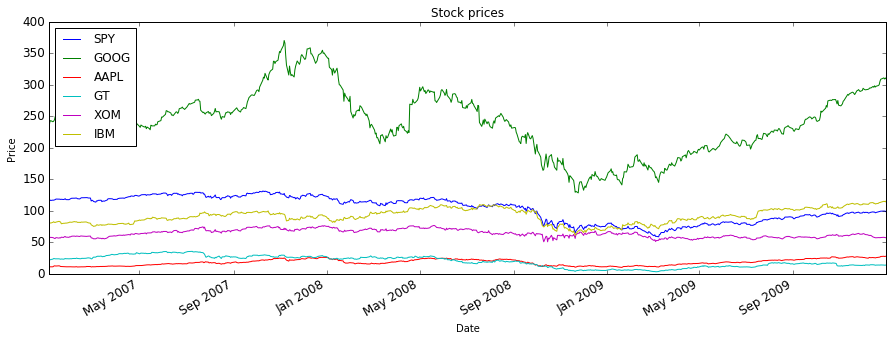

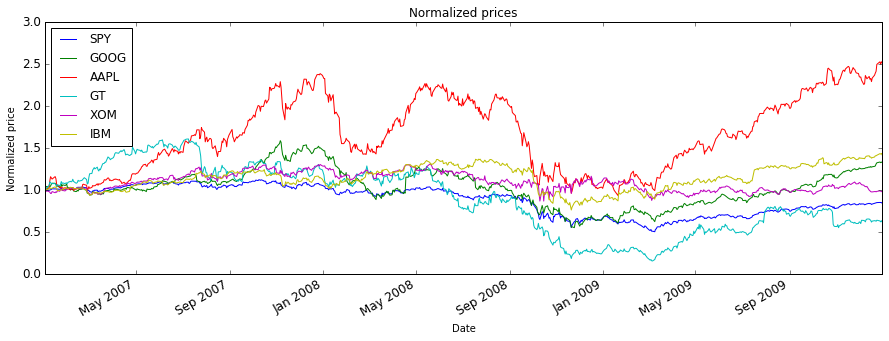

In [8]:
sd = dt.datetime(2007,1,1)
ed = dt.datetime(2010,1,1)
data = get_data(tickers, sd, ed)
plot_data(data)
plot_normalized_data(data)

The first graph is showing the stock price and the second is showing the normalized version.

# Feature Analysis

For this project we will train a regression learner on data from a date range.  These data will be our training data.

- For the X values, we will implement several technical features that we believe may be predictive of future return. We will implement them so they output values typically ranging from -1.0 to 1.0.  This will help avoid the situation where one feature overwhelms the results.

- For the Y vlaues: we will not use the price but 7 days return.  Our goal is to predict the future...

So our predictor variables are made up of three technical indicators details below.  The response is the proportional change in prices which will occur over the next 7 days.
We will first train on the 2008/2009 period and test on the 2010 period.

Instead of classical dataset where we can pick data point randomly for our training and testing dataset, with time series data we should select the data in sequence.

# Indicators

Three indicators were chosen to make predictions.  As all indicators were on different scales, they were all normalized to be between -1 and 1.
There are many different predictors that we could use but to limit ourself we decided to select only three ratio.
These ratio has not been selected randomly, in fact they are commonly used in technical analysis because these ratio are good indicator of up and down signals.

    1) Bollinger Bands Ratio (overlap studies)
    ------------------------------------------
A **Bollinger Band** is a band plotted two standard deviations away from a single moving average, developed by famous technical trader John Bollinger.
In our case the price of the stock is banded by an upper and lower band along with a 30 days simple moving average.
Because standard deviation is a measure of volatility, Bollinger Bands adjust themselves to the market conditions. When the markets become more volatile, the bands widen (move further away from the average), and during less volatile periods, the bands contract (move closer to the average). The tightening of the bands is often used by technical traders as an early indication that the volatility is about to increase sharply.

Here is a simple illustration of the BB. The price of the stock is banded by an upper and lower band along 5 days simple moving average.

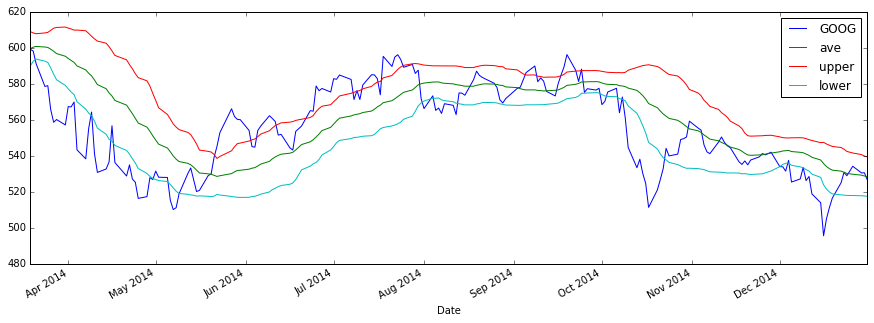

In [10]:
def bbands(price, length=30, numsd=2):
    """ returns average, upper band, and lower band"""
    ave = pd.stats.moments.rolling_mean(price,length)
    sd = pd.stats.moments.rolling_std(price,length)
    upband = ave + (sd*numsd)
    dnband = ave - (sd*numsd)
    return np.round(ave,3), np.round(upband,3), np.round(dnband,3)

sd = dt.datetime(2000,1,1)
ed = dt.datetime(2015,1,1)
prices_all = get_data(['GOOG'], sd, ed, addSPY=False)
prices_all['ave'], prices_all['upper'], prices_all['lower'] = bbands(prices_all, length=30, numsd=1)
prices_all= prices_all[-200:]
prices_all.plot()

By itself, the BB bands are not interesting.  The relative location of the price withing the band is more important so we calculated our BB ratio as:

$$ bb_{ratio}=\frac{price_{current}-SMA_{20 days}}{2 * sd_{20 days}} $$ 

    2) MACD - Moving Average Convergence/Divergence (momentum indicator)
    --------------------------------------------------------------------
**Moving average convergence divergence (MACD)** is a trend-following momentum indicator that shows the relationship between two moving averages of prices. The MACD is calculated by subtracting the 26-day exponential moving average (EMA) from the 12-day EMA. A nine-day EMA of the MACD, called the "signal line", is then plotted on top of the MACD, functioning as a trigger for buy and sell signals.
For more information, visit [investopedia](http://www.investopedia.com/terms/m/macd.asp) or [Indicator Reference](http://www.fmlabs.com/reference/default.htm?url=MACD.htm).

The Moving Average Convergence Divergence (MACD) is the difference between two Exponential Moving Averages. The Signal line is an Exponential Moving Average of the MACD.

$$ shortema = 0.15 * price + 0.85 * shortema_{20 days} $$
$$ longema = 0.075 * price + 0.925 * longema_{20 days} $$
$$ MACD = shortema - longema $$

    3) Mementum
    -----------
    
The Momentum indicator measures the amount that a security's price has changed over a given time span.
It is a measurement of the acceleration and deceleration of prices. It indicates if prices are increasing at an increasing rate or decreasing at a decreasing rate. The Momentum function can be applied to the price, or to any other data series. 

$$ Momentum = price - price_{20 days} $$

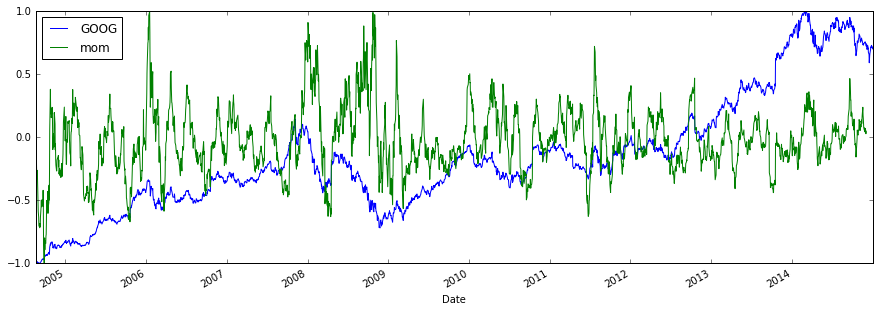

In [11]:
sd = dt.datetime(2000,1,1)
ed = dt.datetime(2015,1,1)
prices_all = get_data(['GOOG'], sd, ed, addSPY=False)
prices_all['mom'] = (prices_all / prices_all.shift(-20)) - 1.0
prices_all = prices_all.apply(lambda x: ((x - np.min(x)))*2 / (np.max(x) - np.min(x))-1)   
prices_all.plot()

Next we implement these indicators,

In [12]:
def indicators(prices, window=20):
    # adjusted close needs to be converted to float and numpy array
    sma = pd.stats.moments.rolling_mean(prices, window) 
    sd = pd.stats.moments.rolling_std(prices, window)
    # Bollinger bands ratio (above upper band is > 1; below lower band <-1)
    bb_ratio = (prices - sma) / (2*sd)
    
    # Moving Average Convergence/Divergence
    macd=pd.ewma(prices,span=window) - pd.ewma(prices,window/2)
    
    # momentum
    mom = (prices / prices.shift(-window)) - 1.0
    
    # combine all to a dataframe 
    df = pd.DataFrame(pd.concat([bb_ratio, macd, mom], axis=1))

    df.columns = ['bb_ratio', 'macd', 'mom']
    df.columns =  [prices.columns.values[0] + '_' + x for x in df.columns]

    # Normalaise the data to between -1 and 1    
    df = df.apply(lambda x: ((x - np.min(x)))*2 / (np.max(x) - np.min(x))-1)   
    return df[[0,1,2]]

## Regression Model

For this project we had the choice to take :

* A **parametric regression** approach (linear regression) where we estimate parameters of a function (could be a line or a more complex function)

* Use an **instance or non-parametric** based approach where the function is only approximated locally (e.g. K-NN or kernel regression)

The decision has been made to go with a non-parametric approach because we don't know in advance what the underline mathematical equation of the model would look like.  As we cannot guess the function of the stock movement, we have to rely on non-parametric approach or instance based model because we can fit any sort of shape to the data.

One advantage of this approach is that the model can evoluate with new data points.  This means we don't have to re-run our model again and again in order to get new predictions for new data.  Training is fast.
On the other had, querying the model could be slow as we have to load all the data.

We decided to use **nearest neighbor** as our predictor but we could also use kernel regression.  The only difference between the two methods is that with kernel regression we weight the contribution of each or the nearest data point according to how distant they are.  With nearest neighbor methods, each data point gets an equal weight.

To avoid overloading this report, only K-NN is used but the reader can easily use kernel regression approach in the next code section and convince himself that the differences between the models is negligeable.

# 7-days regression learner using K-NN

For our learning regression algorithm, we used **KNeighbors regressor** with a **grid search** technique in order to find the optimal hyperparameters of the model.

When the outcome is a number, the most common method for characterising a model’s predictive capabilities is to use the mean squared error (MSE). This metric is a function of the model residuals, which are the observed values minus the model predictions. The MSE is calculated by squaring the residuals and summing them.
In this project we choose to use the **Root Mean Squared Error (RMSE)**. It is just the square root of the mean square error. That is probably the most easily interpreted statistic, since it has the same units as the quantity plotted on the vertical axis.

In [69]:
def MSE(X, y):
    mse = mean_squared_error(X, y)
    print 'MSE: %2.3f' % mse
    return mse

def R2(X, y):    
    r2 = r2_score(X, y)
    print 'R2: %2.3f' % r2
    return r2

def MAE(X, y):
    MAE = mean_absolute_error(X, y)
    print 'MAE: %2.3f' % MAE
    return MAE

def RMSE(X, y):
    RMSE = np.sqrt(mean_squared_error(X, y))
    #print 'RMSE: %2.3f' % RMSE
    return RMSE

def two_score(X, y):    
    #score = MSE(X, y) 
    score = RMSE(X, y) #set score here and not below if using MSE in GridCV
    #score = MAE(X, y) #set score here and not below if using MSE in GridCV
    #score = R2(X, y) #set score here and not below if using MSE in GridCV
    return score

def two_scorer():
    # This will take care of standardizing our function so that scikit's objects know how to use is.  
    # Because this is a loss function and not a score functon, the lower the better, 
    #and thus the need to let sklean to flip the sign to turn this form a maximization problem into 
    #a minimization problem.
    return make_scorer(two_score, greater_is_better=False)

def fit_predict_model(X_train, y_train, X_test, y_test):
    # K-NN regressor
    regressor = KNeighborsRegressor()
    # parameters for K-NN
    parameters = {
        'n_neighbors': range(10, 100), # Number of neighbors to use by default for k_neighbors queries.
        'weights': ['uniform', 'distance'], # weight function used in prediction / weigh the contribution of each of 
                                           # the k neighbors according to their distance to the query
        'metric': ['minkowski','euclidean','manhattan'] # the distance metric to use for the tree.
    }
    # Ridge kernel regressor
    #regressor = KernelRidge()
    # parameters for ridge regression with the kernel trick
    #parameters = {"alpha": [1e0, 0.1, 1e-2, 1e-3],"gamma": np.logspace(-2, 2, 5)}
    reg = GridSearchCV(
        estimator = regressor,
        param_grid=[parameters],
        scoring=two_scorer(),
        cv=10
    )
    print "Final Model: "
    reg.fit(X_train, y_train)
    best_params = reg.best_params_
    score = reg.best_score_
    # Enable this section to see the grid score
    #for item in reg.grid_scores_:
    #    print "\t%s %s %s" % ('\tGRIDSCORES\t',  "RMSE" , item)
    print '%s\tHP\t%s\t%f' % ("RMSE" , str(best_params) ,abs(score))
    y_lr = reg.predict(X_test)
    print "\tKNN corr %0.4f" %(np.corrcoef(y_test, y_lr)[0,1])
    print "\tKNN mean %0.4f" %(abs(y_test - y_lr).mean())
    print "\tActual mean 5 day change %0.4f" %abs(y_test).mean()
    return y_lr

# Generate our training/testing data

For our data we are using the two trading years of data for our training data and one year of data for the testing data.  this makes a ratio 66/33 data split.

In [48]:
# dates for the training data
sd_i = dt.datetime(2008,1,1)
ed_i = dt.datetime(2009,12,31)
# dates for the testing data
sd_o = dt.datetime(2010,1,1)
ed_o = dt.datetime(2010,12,31)
# overall dates for the dataset
sd = dt.datetime(2000,1,1)
ed = dt.datetime(2015,1,1)
prices_all = get_data(tickers, sd, ed)
prices = prices_all[tickers] # only portfolio symbols

# Makes prediction

For each ticker in our portfolio we are making a 7 day predictions.
To compare the goodness of our prediction we are storing the actual price, the actual price + 7 days and the actual price + 7 days predicted by our model.

In [70]:
preds = pd.DataFrame(index=prices[sd_o : ed_o].index)

for ticker in prices.columns:  # we train and predict for each ticker
    df = pd.DataFrame(prices[ticker])
    X_train = indicators(df)[sd_i : ed_i].as_matrix()
    y_train = df.pct_change(7).shift(-7)[sd_i : ed_i].as_matrix()[:,0]
    X_test = indicators(df)[sd_o : ed_o].as_matrix()
    y_test = df.pct_change(7).shift(-7)[sd_o : ed_o].as_matrix()[:,0]
    # Makes prediction
    print "Make prediction for " + ticker
    ypred = fit_predict_model(X_train, y_train, X_test, y_test)
    preds['Actual Price ' + ticker] = prices[ticker][sd_o : ed_o]
    preds['Actual Day+7 Price ' + ticker] = prices[ticker].shift(-5)[sd_o : ed_o]
    preds['Actual Day+7 Price learner ' + ticker] = preds['Actual Price ' + ticker] * (1 - ypred)
    print '######################################################################################'

Make prediction for GOOG
Final Model: 
RMSE	HP	{'n_neighbors': 55, 'metric': 'minkowski', 'weights': 'uniform'}	0.051491
	KNN corr 0.5060
	KNN mean 0.0329
	Actual mean 5 day change 0.0372
######################################################################################
Make prediction for AAPL
Final Model: 
RMSE	HP	{'n_neighbors': 14, 'metric': 'manhattan', 'weights': 'uniform'}	0.062593
	KNN corr 0.4592
	KNN mean 0.0316
	Actual mean 5 day change 0.0376
######################################################################################
Make prediction for GT
Final Model: 
RMSE	HP	{'n_neighbors': 16, 'metric': 'manhattan', 'weights': 'distance'}	0.102104
	KNN corr 0.3692
	KNN mean 0.0683
	Actual mean 5 day change 0.0608
######################################################################################
Make prediction for XOM
Final Model: 
RMSE	HP	{'n_neighbors': 66, 'metric': 'manhattan', 'weights': 'distance'}	0.040777
	KNN corr 0.5260
	KNN mean 0.0209
	Actual mean 5 day ch

From the previous output we can see that we are getting a pretty good **RMSE score** for each ticket. For this value, the smaller is better.
Another quantitative metric we are displaying is the **correlation** between our predicted output and the true value/actual value of the market.  Also we can see we are getting relatively good correlation.

In the grid search, we tunned our regressor for various parameters.  The details of each of them is available in the code.  We can noticed that the main parameter is obviously the number or neighbors used for the local function evaluation.

Let's visualize the prediction for a ticker and see if our model is doing well...

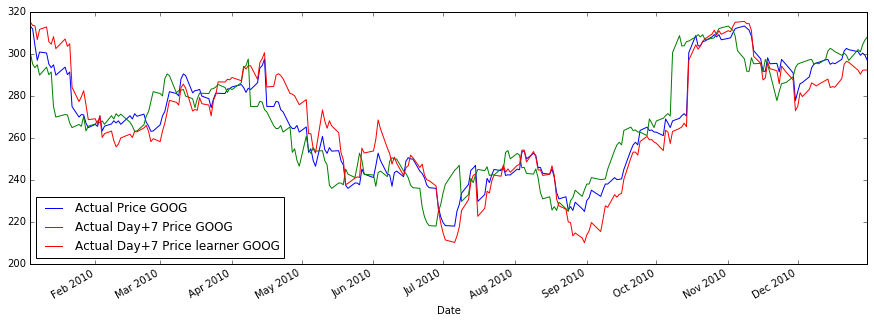

In [73]:
prices_GOOG = pd.DataFrame(pd.concat([preds['Actual Price ' + tickers[0]], 
                           preds['Actual Day+7 Price ' + tickers[0]], 
                           preds['Actual Day+7 Price learner ' + tickers[0]]],
                           axis=1, 
                           keys=['Actual Price ' + tickers[0], 
                                         'Actual Day+7 Price ' + tickers[0], 
                                         'Actual Day+7 Price learner ' + tickers[0]]))
prices_GOOG.plot()

As we can see simply by navigating through the graph, our prediction is quite accurate.  We can already conclude that our model is following the trends but it doesn't make a great job at over-performing the trend...  More generally we can see that our predicted price is often below the actual + 7 days.  Nonetheless, the variance of the model does not looks terrible.

In [74]:
# Build a dataframe that will be used later for out optimized portfolio...
sd_o = dt.datetime(2010,1,1)
ed_o = dt.datetime(2010,12,31)
spy = pd.DataFrame(prices_all['SPY'][sd_o:ed_o])
price_all_ = pd.DataFrame(pd.concat(
    [preds['Actual Day+7 Price learner ' + ticker] for ticker in tickers],
    axis=1))
price_all_.columns = tickers
price_all_pred = pd.concat([price_all_, spy], axis=1)

## Assess portfolio

A portfolio is a collection of stocks (or other assets) and corresponding allocations of funds to each of them. In order to evaluate and compare different portfolios, we first need to compute certain metrics, based on available historical data.

This section is introducing portfolio analysis.  We will be calculating various statics and plotting a comparison graph.

This function computes statistics about on a portfolio.
The returned outpus are :
    * cr: Cumulative return
    * adr: Average period return (if sf == 252 this is daily return)
    * sddr: Standard deviation of daily return
    * sr: Sharpe ratio
    * ev: End value of portfolio
The input parameters are :
    * sd: A datetime object that represents the start date
    * ed: A datetime object that represents the end date
    * syms: A list of symbols that make up the portfolio (note that your code should support any symbol in the data directory)
    * allocs: A list of allocations to the stocks, must sum to 1.0
    * sv: Start value of the portfolio
    * rfr: The risk free return per sample period for the entire date range. We assume that it does not change.
    * sf: Sampling frequency per year
    * gen_plot: If True, create a plot named plot.png

In [18]:
def compute_daily_returns(df):
    """Compute and return the daily return values."""
    daily_returns = df.copy()
    daily_returns[1:] = (df[1:] / df[:-1].values) - 1 # compute daily returns fo row 1 onwards
    daily_returns.ix[0] = 0 # set daily returns for row 0 to 0
    # much easier with Pandas !
    # daily_returns = (df / df.shift(1)) - 1
    # daily_returns.ix[0, :] = 0
    return daily_returns

In [19]:
def compute_stat(port_val, sf, rfr):
    # compute the daily returns
    daily_rets = compute_daily_returns(port_val)
    daily_rets = daily_rets[1:]
    
    # Cumulative return
    cr = (port_val[-1]/port_val[0]) - 1
    # Average daily return
    adr = daily_rets.mean()
    # Risk
    sddr = daily_rets.std()
    # sharp ratio : risk adjusted return
    sr = np.sqrt(sf) * (adr - rfr) / sddr
    return cr, adr, sddr, sr

In [20]:
def assess_portfolio(sd = dt.datetime(2008,1,1), ed = dt.datetime(2009,1,1), \
    syms = ["GOOG", "AAPL", "GT", "XOM"], \
    allocs=[0.1,0.2,0.3,0.4], \
    sv=1000000, rfr=0.0, sf=252.0, \
    gen_plot=False):

    # Read in adjusted closing prices for given symbols, date range
    prices_all = get_data(syms, sd, ed)  # automatically adds SPY
    prices = prices_all[syms]  # only portfolio symbols
    prices_SPY = prices_all['SPY']  # only SPY, for comparison later
    
    # Get daily portfolio value
    normed = prices/prices.ix[0, :]
    alloced = normed * allocs
    pos_vals = alloced * sv
    port_val = pos_vals.sum(axis=1)  # value each day

    # Get portfolio statistics (note: std_daily_ret = volatility)
    cr, adr, sddr, sr = compute_stat(port_val, sf, rfr)

    # Compare daily portfolio value with SPY using a normalized plot
    if gen_plot:
        # add code to plot here
        prices_SPY_norm = prices_SPY/prices_SPY.ix[0, :]
        port_val_norm = port_val / port_val.ix[0, :]
        df_temp = pd.concat([port_val_norm, prices_SPY_norm], keys=['Portfolio', 'SPY'], axis=1)
        plot_data(df_temp, title="Daily portfolio value and SPY", ylabel="Normilized price")

    # Add code here to properly compute end value
    ev = port_val.ix[-1,0]
    
    return cr, adr, sddr, sr, ev

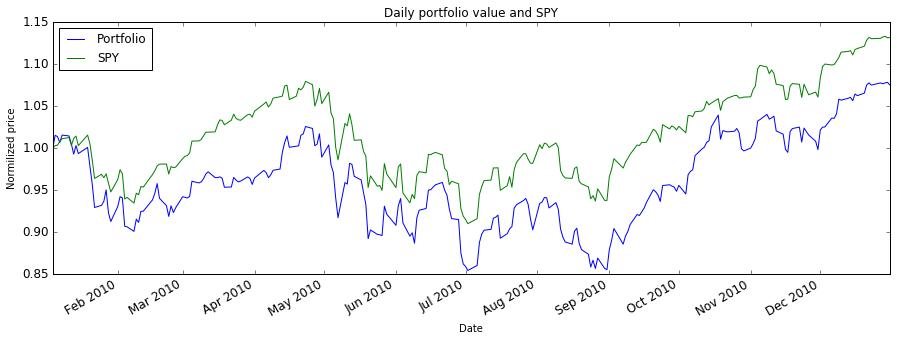

Start Date: 2010-01-01 00:00:00
End Date: 2010-12-31 00:00:00
Symbols: ['GOOG', 'AAPL', 'GT', 'XOM', 'IBM']
Allocations: [ 0.05395473  0.14204312  0.26193796  0.28217281  0.25989138]
Sharpe Ratio: 0.446820624677
Volatility (stdev of daily returns): 0.0134406043184
Average Daily Return: 0.000378313410917
Cumulative Return: 0.07501183942
Start value 1000000
End value 1075011.83942


In [30]:
start_date = dt.datetime(2010,1,1)
end_date = dt.datetime(2010,12,31)
symbols = tickers
# pick random allocations
allocations = np.random.random(len(tickers))
allocations /= allocations.sum()
start_val = 1000000  
risk_free_rate = 0.0
sample_freq = 252

# Assess the portfolio
cr, adr, sddr, sr, ev = assess_portfolio(sd = start_date, ed = end_date,\
    syms = symbols, \
    allocs = allocations,\
    sv = start_val, \
    gen_plot = True)

# Print statistics
print "Start Date:", start_date
print "End Date:", end_date
print "Symbols:", symbols
print "Allocations:", allocations
print "Sharpe Ratio:", sr
print "Volatility (stdev of daily returns):", sddr
print "Average Daily Return:", adr
print "Cumulative Return:", cr
print "Start value", start_val
print "End value", ev

The most important statistics in this output is the **sharp ratio**. The Sharpe Ratio is a measure for calculating risk-adjusted return, and this ratio has become the industry standard for such calculations.

What we would like is actually create an optimized version of our portfolio with regards to this sharp ratio.

# Optimize portfolio

In this section we will use an optimizers to optimize portfolio.  That means, we will find how much of a portfolio's funds should be allocated to each stock so as to optimize it's performance.  In this case we define "optimal" as maximum Sharpe ratio.

The following function can find the optimal allocations for a given set of stocks.

Where the returned output is:

    * allocs: A 1-d Numpy ndarray of allocations to the stocks. All the allocations must be between 0.0 and 1.0 and they must sum to 1.0.
    * cr: Cumulative return
    * adr: Average daily return
    * sddr: Standard deviation of daily return
    * sr: Sharpe ratio

The input parameters are:

    * sd: A datetime object that represents the start date
    * ed: A datetime object that represents the end date
    * syms: A list of symbols that make up the portfolio (note that your code should support any symbol in the data directory)
    * gen_plot: If True, create a plot named plot.png

Here we are facing an optimization problem where we have to optimize for sharp ratio.

    1. we have to first provide a function (larger sharp ratio)
    2. we have to provide an initial guess for X.  Here X is the stock allocation.
    3. call the optimize

In [31]:
def error_poly(C, data):
    # Metric : sharp-ratio
    sv=1000000 
    rfr=0.0
    sf=252.0
    
    normed = data/data.ix[0, :]
    alloced = normed * C
    pos_vals = alloced * sv
    port_val = pos_vals.sum(axis=1)
    
    daily_rets = compute_daily_returns(port_val)
    daily_rets = daily_rets[1:]
    adr = daily_rets.mean()
    sddr = daily_rets.std()
    sr = np.sqrt(sf) * (adr - rfr) / sddr
    return sr * (-1) # -1 otherwise we are minimizing the sr ...

In [32]:
def fit_poly(data, error_func, degree=3):
    Cguess = degree * [1. / degree]
    bnds = ((0.0,1.0),) * degree # create bounds for every coeficient
    result = spo.minimize(error_func, Cguess, args=(data,), 
                          method='SLSQP',                           
                          constraints = ({ 'type': 'eq', 'fun': lambda inputs: 1.0 - np.sum(inputs) }),
                          bounds = bnds,
                          options={'disp':True})
    return result.x

In [33]:
def optimize_portfolio(sd=dt.datetime(2008,1,1), 
                       ed=dt.datetime(2009,1,1), \
                       syms=['GOOG','AAPL','GT','XOM'], 
                       gen_plot=False,
                       prices_all=None): 
    sv=1000000 
    rfr=0.0
    sf=252.0
    # Read in adjusted closing prices for given symbols, date range
    if prices_all is None:
        prices_all = get_data(syms, sd, ed)  # automatically adds SPY
    prices = prices_all[syms]  # only portfolio symbols
    prices_SPY = prices_all['SPY']  # only SPY, for comparison later
    
    allocs = np.asarray(fit_poly(prices, error_poly, len(syms)))
    
    # Get daily portfolio value
    normed = prices/prices.ix[0, :]
    alloced = normed * allocs
    pos_vals = alloced * sv
    port_val = pos_vals.sum(axis=1)  # value each day
    
    cr, adr, sddr, sr = compute_stat(port_val, sf, rfr)
    df_temp = None
    # Compare daily portfolio value with SPY using a normalized plot
    if gen_plot:
        prices_SPY_norm = prices_SPY/prices_SPY.ix[0, :]
        port_val_norm = port_val / port_val.ix[0, :]
        df_temp = pd.concat([port_val_norm, prices_SPY_norm], keys=['Portfolio', 'SPY'], axis=1)
        plot_data(df_temp, title="Daily portfolio value and SPY", ylabel="Normilized price")
        
    ev = port_val.ix[-1,0]

    return allocs, cr, adr, sddr, sr, ev, df_temp

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1.67247012635
            Iterations: 2
            Function evaluations: 14
            Gradient evaluations: 2


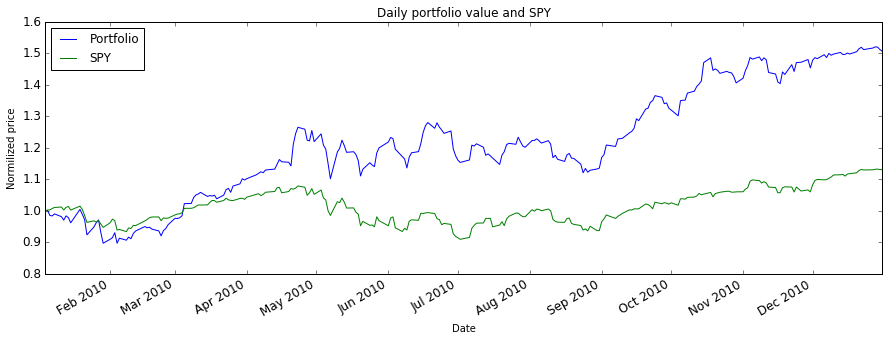

Start Date: 2010-01-01 00:00:00
End Date: 2010-12-31 00:00:00
Symbols: ['GOOG', 'AAPL', 'GT', 'XOM', 'IBM']
Allocations: [  0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   4.71844785e-16]
Sharpe Ratio: 1.67247012635
Volatility (stdev of daily returns): 0.0168675779839
Average Daily Return: 0.00177709573862
Cumulative Return: 0.507219372452
End value 1507219.37245


In [34]:
start_date = dt.datetime(2010,1,1)
end_date = dt.datetime(2010,12,31)
symbols = tickers

# Assess the portfolio
allocations, cr, adr, sddr, sr, ev, df = optimize_portfolio(sd = start_date, ed = end_date,\
    syms = symbols, \
    gen_plot = True)

portfolio1 = pd.DataFrame()
portfolio1 = pd.concat([df], axis=1)
portfolio1.columns = ['Daily portfolio', 'SPY']

# Print statistics
print "Start Date:", start_date
print "End Date:", end_date
print "Symbols:", symbols
print "Allocations:", allocations
print "Sharpe Ratio:", sr
print "Volatility (stdev of daily returns):", sddr
print "Average Daily Return:", adr
print "Cumulative Return:", cr
print "End value", ev

Finally, let's apply our optimized portfolio logic to the KNN model to see final portfolio value from our fictive $10k.

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1.07083625807
            Iterations: 2
            Function evaluations: 14
            Gradient evaluations: 2


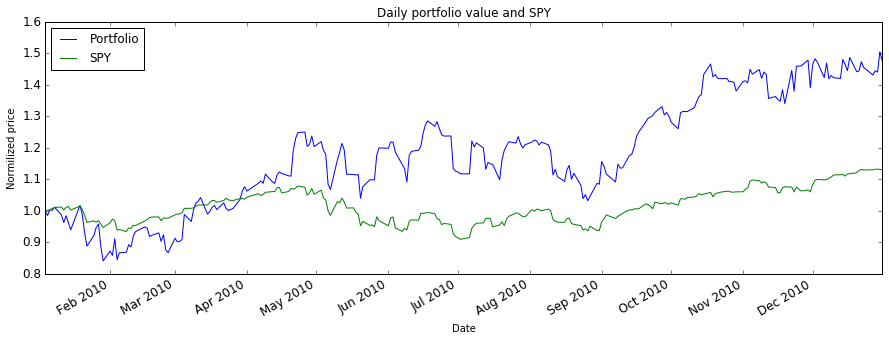

Start Date: 2010-01-01 00:00:00
End Date: 2010-12-31 00:00:00
Symbols: ['GOOG', 'AAPL', 'GT', 'XOM', 'IBM']
Allocations: [  1.94289029e-16   1.00000000e+00   3.88578059e-16   0.00000000e+00
   0.00000000e+00]
Sharpe Ratio: 1.07083625807
Volatility (stdev of daily returns): 0.0293924572335
Average Daily Return: 0.00198270769615
Cumulative Return: 0.476542000312
End value 1476542.00031


In [71]:
start_date = dt.datetime(2010,1,1)
end_date = dt.datetime(2010,12,31)
symbols = tickers

# Assess the portfolio
allocations, cr, adr, sddr, sr, ev, df = optimize_portfolio(sd = start_date, ed = end_date,\
    syms = symbols, \
    gen_plot = True, \
    prices_all = price_all_pred)

portfolio2 = pd.DataFrame()
portfolio2 = pd.concat([df], axis=1)
portfolio2.columns = ['Predicted portfolio', 'SPY']

# Print statistics
print "Start Date:", start_date
print "End Date:", end_date
print "Symbols:", symbols
print "Allocations:", allocations
print "Sharpe Ratio:", sr
print "Volatility (stdev of daily returns):", sddr
print "Average Daily Return:", adr
print "Cumulative Return:", cr
print "End value", ev

Putting everything together...

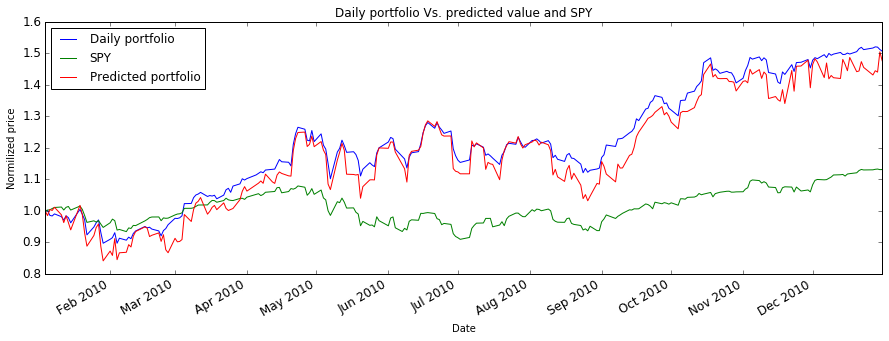

In [72]:
portfolio = pd.DataFrame(pd.concat([portfolio1,portfolio2], axis=1))
# remove duplicate SPY columns
portfolio = portfolio.T.drop_duplicates().T
plot_data(portfolio, title="Daily portfolio Vs. predicted value and SPY", ylabel="Normilized price")

# Conclusion

All relevant metrics for the performance of the portfolio can been seen in the previous output.  The results are clearly showing that our model is not over performing the market. However, this model could be a good basis for futher model, more advanced where other learner are used.  For example linear regression or bagging.

With our initial \$10k we end-up with a slithly smaller return with the predicted model than with the true value of the market.  However we can confirm that our model is following quite well the market movment.

The next logical step of this project would be to create a trading simulator and simulate a trading strategy based on our model.  This simulator would be responsible to buy, sell or hold stocks in order to maximise the return. Obviously it goes beyond the scope of this project.

Here is an illustration showing a possible decision tree for a simulator based on predictions :

![simulator strategy](assets/decision_tree_sim.png "Simulator")

# Limitations

The model as implemented here has some serious limitations that should be taken into consideration.

* **Survivor bias**. Survivorship bias is the tendency for failed companies to be excluded from performance studies because they no longer exist. It often causes the results of studies to skew higher because only companies which were successful enough to survive until the end of the period are included.  As we are using free, public data we are not sure that the data have been cleaned with this bias in consideration.

* **Look-ahead bias**: The whole history is available to us which makes it very easy to use information we would not have access to.

* **Transaction cost**: The model presented here is not taking into acount the transaction cost if we had to buy or sell shares.  This project does not touch this aspect of the problem but a more advanced version of model price prediction should take transaction cost into consideration.